<a href="https://colab.research.google.com/github/UznetDev/Data-science-homework/blob/main/DAY_15_home_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('planes.csv')

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
2,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0
3,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,non-stop,No info,3873.0
4,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10660 entries, 0 to 10659
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          10233 non-null  object 
 1   Date_of_Journey  10338 non-null  object 
 2   Source           10473 non-null  object 
 3   Destination      10313 non-null  object 
 4   Route            10404 non-null  object 
 5   Dep_Time         10400 non-null  object 
 6   Arrival_Time     10466 non-null  object 
 7   Duration         10446 non-null  object 
 8   Total_Stops      10448 non-null  object 
 9   Additional_Info  10071 non-null  object 
 10  Price            10044 non-null  float64
dtypes: float64(1), object(10)
memory usage: 916.2+ KB


In [ ]:
df.describe()

,Price
count,10044.000000
mean,9044.411191
std,4472.304869
min,1759.000000
25%,5276.750000
50%,8366.000000
75%,12373.000000
max,54826.000000


In [ ]:
df.shape

(10660, 11)

#### Qaysi ustunda qancha nan borligini kurib olamiz

In [ ]:
for i in df.columns:
    print(i, df[i].isna().sum())

Airline 427
Date_of_Journey 322
Source 187
Destination 347
Route 256
Dep_Time 260
Arrival_Time 194
Duration 214
Total_Stops 212
Additional_Info 589
Price 616


##### Nan qiymatlarni bog'liq ustunlar orqaliy almashtiramiz

In [ ]:
frequent_airlines = df[df['Airline'].notna()].groupby('Duration')['Airline'].transform(lambda x: x.mode()[0] if not x.mode().empty else x)
df['Airline'] = df['Airline'].fillna(frequent_airlines)

In [ ]:
df['Duration_na'] = df['Duration'].isna()
df['Duration'] = pd.to_timedelta(df['Duration'], errors='coerce')
mean_durations = df.groupby('Route')['Duration'].transform('mean')
df['Duration'] = df['Duration'].fillna(mean_durations)

In [ ]:
mean_prices = df[df['Price'].notna()].groupby(by=['Route', 'Date_of_Journey', 'Additional_Info'])['Price'].mean().reset_index()
df = pd.merge(df, mean_prices, on=['Route', 'Date_of_Journey', 'Additional_Info'], how='left', suffixes=('', '_mean'))
df['Price'] = df['Price'].fillna(df['Price_mean'])
df.drop(columns=['Price_mean'], inplace=True)
mean_prices = df[df['Price'].notna()].groupby(by=['Route', 'Date_of_Journey'])['Price'].mean().reset_index()
df = pd.merge(df, mean_prices, on=['Route', 'Date_of_Journey'], how='left', suffixes=('', '_mean'))
df['Price'] = df['Price'].fillna(df['Price_mean'])
df.drop(columns=['Price_mean'], inplace=True)

In [ ]:
route_fill = df[df['Route'].notna()].groupby(['Source', 'Duration'])['Route'].agg(pd.Series.mode).reset_index()
df = df.merge(route_fill, on=['Source', 'Duration'], how='left', suffixes=('', '_mode1'))
df['Route'] = df['Route'].fillna(df['Route_mode1'])
route_fill = df.groupby(['Source', 'Destination'])['Route'].agg(pd.Series.mode).reset_index()
df = df.merge(route_fill, on=['Source', 'Destination'], how='left', suffixes=('', '_mode2'))
df['Route'] = df['Route'].fillna(df['Route_mode2'])
df.drop(columns=['Route_mode2'], inplace=True)
df.drop(columns=['Route_mode1'], inplace=True)

In [ ]:
def fill_nan_values(row):
    route = row['Route']
    if isinstance(route, str):
        route_parts = route.split(' → ')
        if pd.isna(row['Source']):
            row['Source'] = route_parts[0]
        if pd.isna(row['Destination']):
            row['Destination'] = route_parts[-1]
    return row

df = df.agg(fill_nan_values, axis=1)

In [ ]:
def calculate(route):
    if isinstance(route, str):
        stops = route.count('→')
        if stops == 0:
            return 'non-stop'
        else:
            return stops
    return None

df['Total_Stops'] = df.agg(
    lambda row: calculate(row['Route']) if pd.isna(row['Total_Stops']) else row['Total_Stops'], axis=1
)

stops = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
df['stop'] = df['Total_Stops'].map(stops, na_action='ignore')
df['stop'] = df['stop'].fillna(0).astype(int)
df.drop(columns=['Total_Stops'], inplace=True)

In [ ]:
df.loc[df['Arrival_Time'].str.len() > 5, 'Date_of_Journey'] = pd.to_datetime(df['Arrival_Time'])
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['week_of_journey'] = df['Date_of_Journey'].dt.strftime('%A')

<ipython-input-783-7a328b2da731>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.loc[df['Arrival_Time'].str.len() > 5, 'Date_of_Journey'] = pd.to_datetime(df['Arrival_Time'])


In [ ]:
df['Dep_Time'].fillna('00:00', inplace=True)
df['Dep_Time'] = pd.to_datetime(df['Dep_Time'], format='%H:%M')

In [ ]:
df['Duration'].fillna('0h 0m', inplace=True)
df['Duration'] = pd.to_timedelta(df['Duration'])
df['Dep_Time'] = df['Dep_Time'].agg(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))

In [ ]:
df['d_total_seconds'] = df['Duration'].dt.total_seconds().astype(int)

#### Arrival_Time ni topish uchun d_total_seconds va Dep_Time ni qushamiz

In [ ]:
df.loc[(df['Date_of_Journey'].notna()) & ((df['Arrival_Time'].isna()) | (df['Arrival_Time'].str.len() <= 5)), 'Arrival_Time'] = \
+ (pd.to_timedelta((df['Dep_Time'].dt.total_seconds() \
+ df['d_total_seconds']), unit='s'))

#### Tozalangandan kiyyingi nanlar sonini kuramiz

In [ ]:
for col in df.columns:
    print(col, df[col].isna().sum())

Airline 427
Date_of_Journey 187
Source 5
Destination 1
Route 5
Dep_Time 0
Arrival_Time 5
Duration 0
Additional_Info 589
Price 53
Duration_na 0
stop 0
week_of_journey 187
d_total_seconds 0


In [ ]:
df.shape

(10660, 14)

##### Ma'lumotlarni vizual kuramiz

<Axes: >

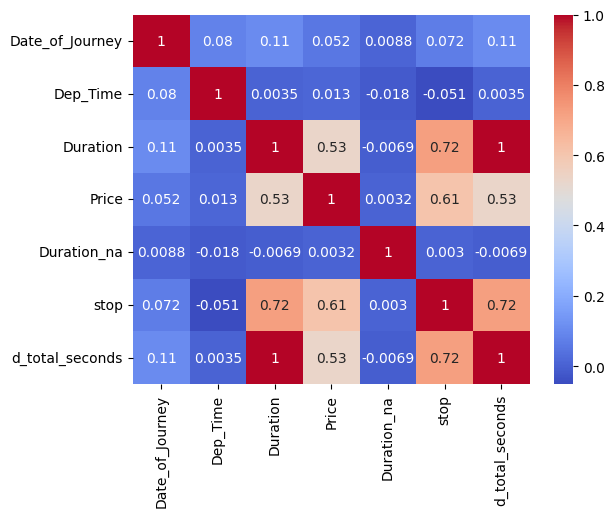

In [ ]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()

sns.heatmap(df.drop(columns=object_cols).corr(), annot=True, cmap='coolwarm')

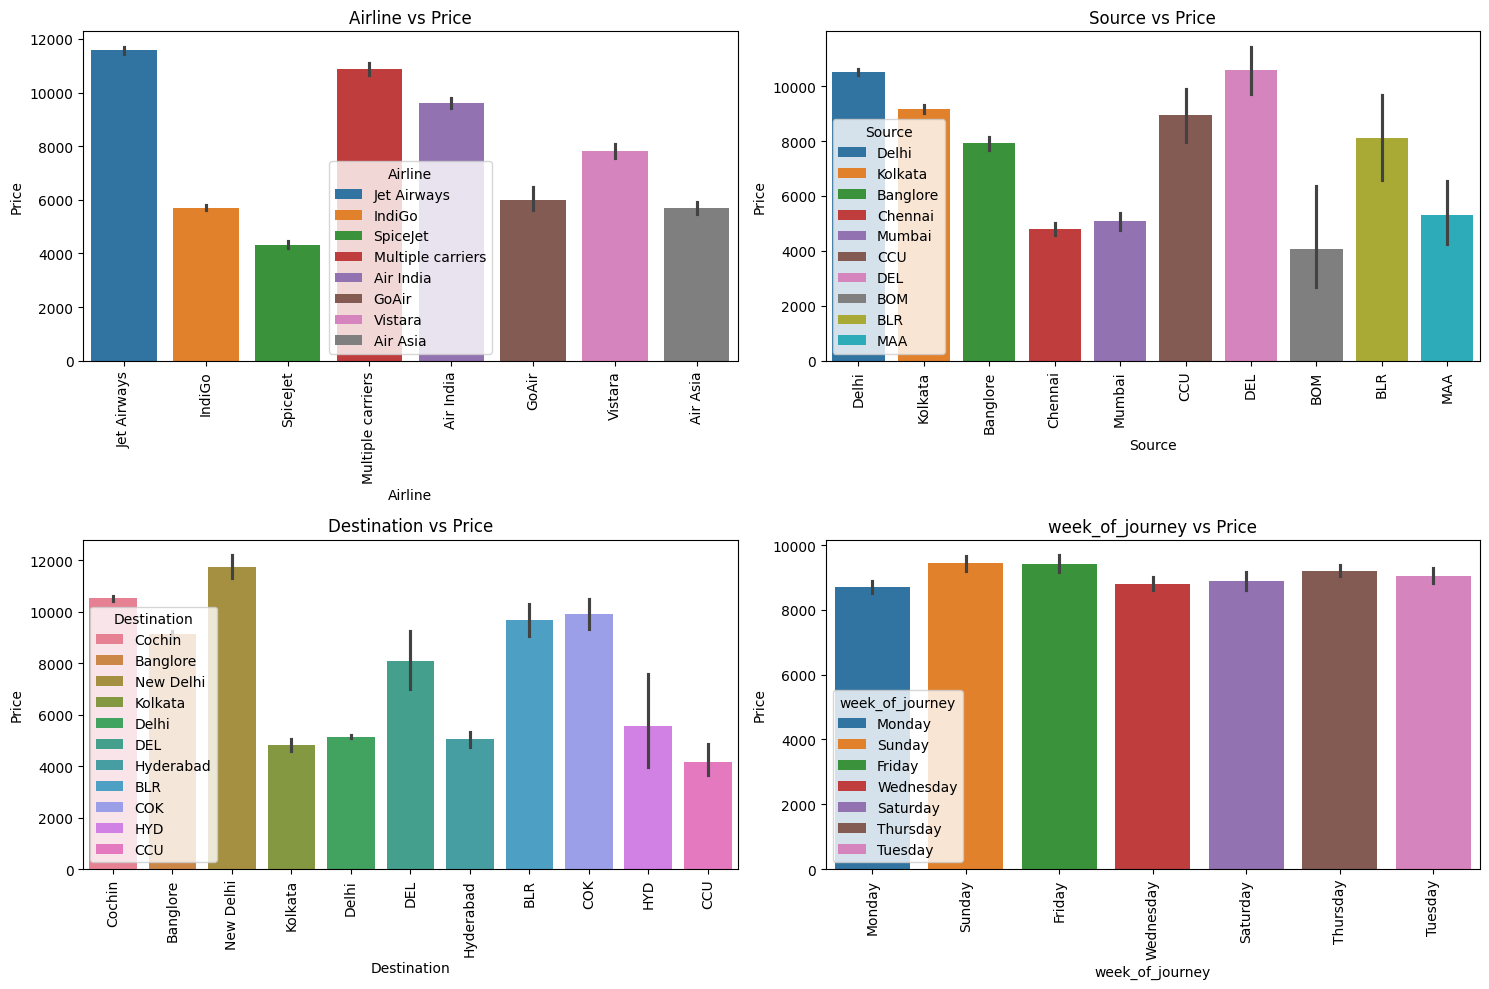

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.barplot(ax=axes[0, 0], x='Airline', y='Price', data=df, hue='Airline')
axes[0, 0].set_title('Airline vs Price')
axes[0, 0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[0, 1], x='Source', y='Price', data=df, hue='Source')
axes[0, 1].set_title('Source vs Price')
axes[0, 1].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1, 0], x='Destination', y='Price', data=df, hue='Destination')
axes[1, 0].set_title('Destination vs Price')
axes[1, 0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1, 1], x='week_of_journey', y='Price', data=df, hue='week_of_journey')
axes[1, 1].set_title('week_of_journey vs Price')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()

In [ ]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Additional_Info', 'Price',
       'Duration_na', 'stop', 'week_of_journey', 'd_total_seconds'],
      dtype='object')

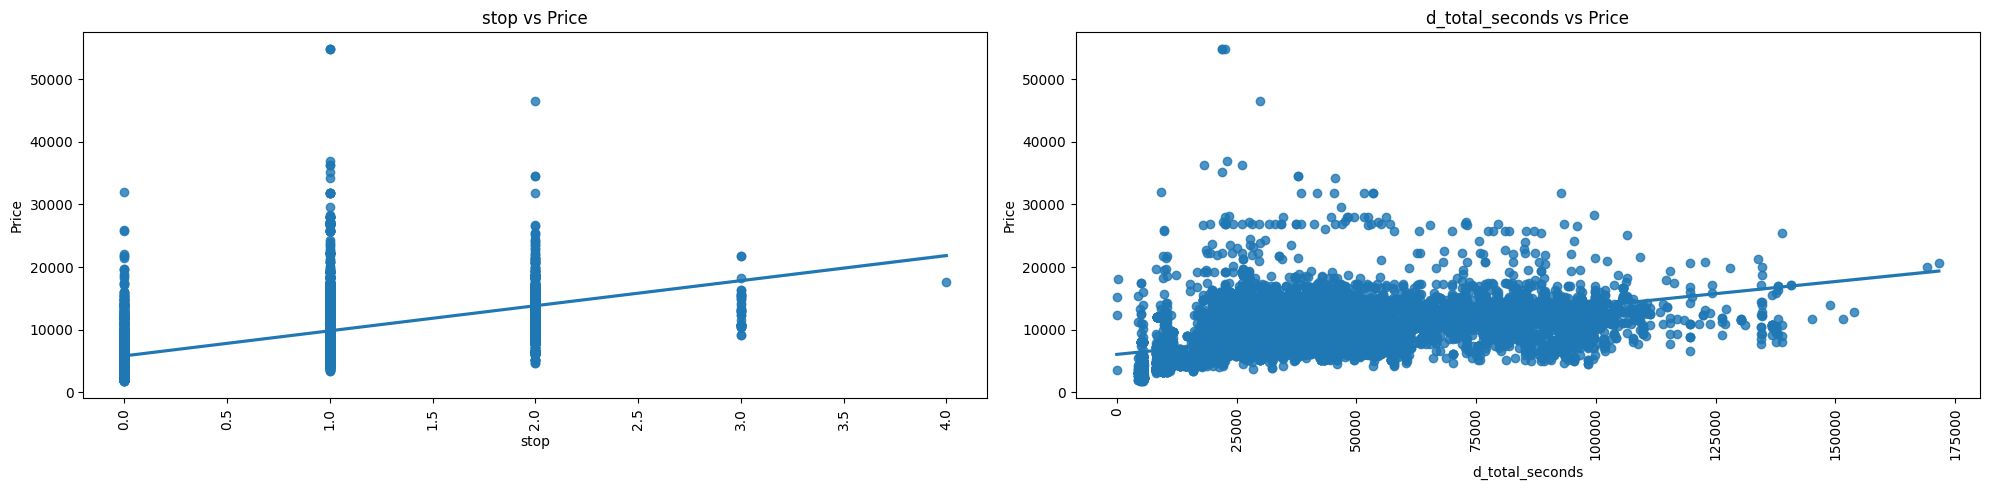

In [ ]:
columns_to_plot = ['stop', 'd_total_seconds']
columns_to_plot = ['Price'] + columns_to_plot
df_clean = df.dropna(subset=columns_to_plot)
fig, axes = plt.subplots(1, len(columns_to_plot) - 1, figsize=(20, 5))
for idx, column in enumerate(columns_to_plot[1:]):
    sns.regplot(ax=axes[idx], x=column, y='Price', data=df_clean)
    axes[idx].set_title(f'{column} vs Price')
    axes[idx].tick_params(axis='x', rotation=90)
plt.tight_layout()